# Damaged induced traps

In [1]:
import numpy as np
import festim as F
import h_transport_materials as htm

D = htm.diffusivities.filter(material="tungsten").filter(author="frauenfelder")[0]

# common values
atom_density_W = 6.3222e28
k_B = F.k_B  # eV K-1
minute = 60
day = minute * 60 * 24
week = day * 7
fpy = day * 365
dpa = 5

my_model = F.Simulation(log_level=40)

# define materials
tungsten = F.Material(D_0=D.pre_exp.magnitude, E_D=D.act_energy.magnitude, id=1)
my_model.materials = F.Materials([tungsten])

# define traps
trap_W_1 = F.Trap(
    k_0=tungsten.D_0 / (1.1e-10**2 * 6 * atom_density_W),
    E_k=tungsten.E_D,
    p_0=1e13,
    E_p=1.04,
    density=2.4e22,
    materials=tungsten,
)
trap_W_damage_4 = F.NeutronInducedTrap(
    k_0=tungsten.D_0 / (1.1e-10**2 * 6 * atom_density_W),
    E_k=tungsten.E_D,
    p_0=1e13,
    E_p=1.85,
    A_0=6.1838e-03,
    E_A=0.30,
    phi=dpa / fpy,
    K=5.0e26,
    n_max=4.7e25,
    materials=tungsten,
)

my_model.traps = F.Traps(
    [
        trap_W_1,
        trap_W_damage_4,
    ]
)

vertices = np.linspace(0, 2e-03, num=1000)
my_model.mesh = F.MeshFromVertices(vertices)

# define temperature
my_model.T = F.Temperature(value=800)

# define boundary conditions
my_model.boundary_conditions = [
    F.ImplantationDirichlet(
        surfaces=1,
        phi=1e20,
        R_p=3e-09,
        D_0=tungsten.D_0,
        E_D=tungsten.E_D,
    ),
]

# define exports
results_folder = "task17/"
my_model.exports = F.Exports(
    [
        F.TXTExport(
            field="retention",
            filename=results_folder + "retention_profile.txt",
            times=[minute, day, week, fpy],
        )
    ]
)

# define settings
my_model.dt = F.Stepsize(
    initial_value=0.1,
    stepsize_change_ratio=1.1,
    dt_min=1e-1,
    milestones=[minute, day, week, fpy],
)
my_model.settings = F.Settings(
    transient=True,
    final_time=fpy,
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    maximum_iterations=30,
)

# run simulation
my_model.initialise()
my_model.run()

[DESKTOP-6T0UN3L:81523] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        3.2e+07 s    Elapsed time so far: 7.1 s


In [16]:
my_standard_model = F.Simulation(
    log_level=40,
    materials=F.Materials([tungsten]),
    traps=F.Traps([trap_W_1]),
    mesh=F.MeshFromVertices(vertices),
    temperature=F.Temperature(800),
    boundary_conditions=[
        F.ImplantationDirichlet(
            surfaces=1,
            phi=1e20,
            R_p=3e-09,
            D_0=tungsten.D_0,
            E_D=tungsten.E_D,
        )
    ],
    exports=F.Exports(
        [
            F.TXTExport(
                field="retention",
                filename=results_folder + "retention_profile_standard.txt",
                times=[minute, day, week, fpy],
            )
        ]
    ),
    dt=F.Stepsize(
        initial_value=0.1,
        stepsize_change_ratio=1.1,
        dt_min=1e-1,
        milestones=[minute, day, week, fpy],
    ),
    settings=F.Settings(
        transient=True,
        final_time=fpy,
        absolute_tolerance=1e05,
        relative_tolerance=1e-10,
    ),
)

my_standard_model.initialise()
my_standard_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        3.2e+07 s    Elapsed time so far: 3.2 s


Text(0, 0.5, 'Retention (m-3)')

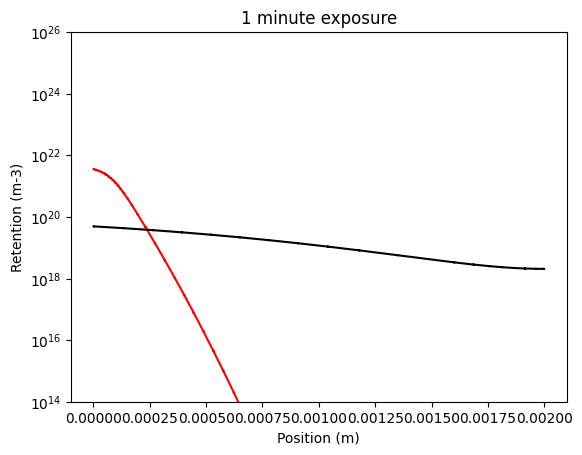

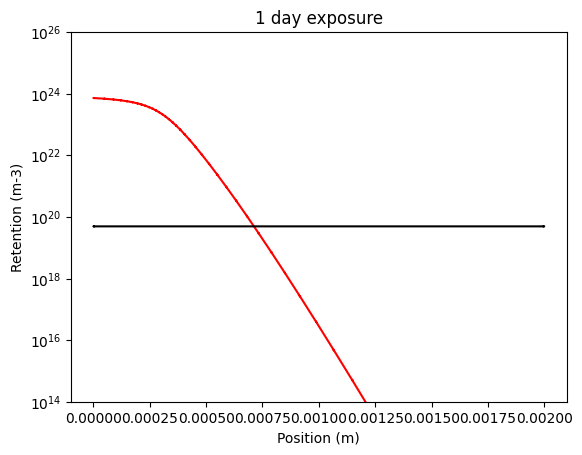

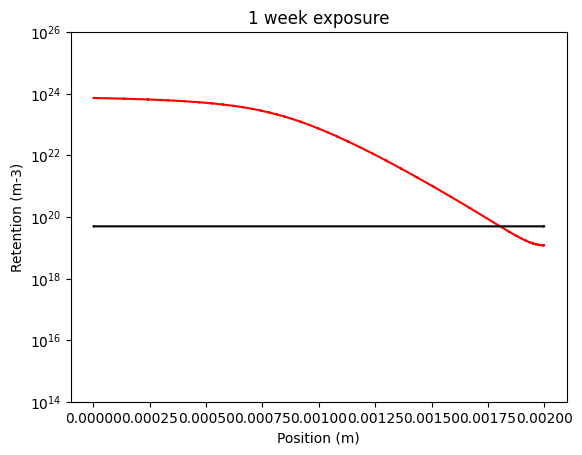

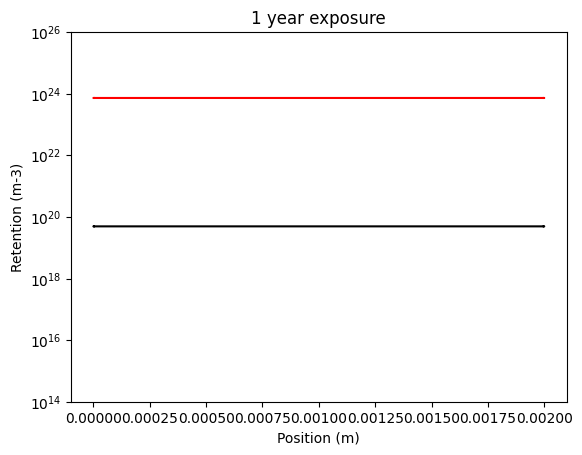

In [17]:
import matplotlib.pyplot as plt
import numpy as np

results_folder = "task17/"

data_damaged = np.genfromtxt(
    results_folder + "retention_profile.txt", delimiter=",", names=True
)
data_standard = np.genfromtxt(
    results_folder + "retention_profile_standard.txt", delimiter=",", names=True
)

t_damage = data_damaged["x"]
t_standard = data_standard["x"]

retention_damage_minute = data_damaged["t600e01s"]
retention_damage_day = data_damaged["t864e04s"]
retention_damage_week = data_damaged["t605e05s"]
retention_damage_fpy = data_damaged["t315e07s"]

retention_standard_minute = data_standard["t600e01s"]
retention_standard_day = data_standard["t864e04s"]
retention_standard_week = data_standard["t605e05s"]
retention_standard_fpy = data_standard["t315e07s"]

plt.figure()
plt.title("1 minute exposure")
plt.plot(t_damage, retention_damage_minute, color="red")
plt.plot(t_standard, retention_standard_minute, color="black")
plt.yscale("log")
plt.ylim(1e14, 1e26)
plt.xlabel("Position (m)")
plt.ylabel("Retention (m-3)")

plt.figure()
plt.title("1 day exposure")
plt.plot(t_damage, retention_damage_day, color="red")
plt.plot(t_standard, retention_standard_day, color="black")
plt.yscale("log")
plt.ylim(1e14, 1e26)
plt.xlabel("Position (m)")
plt.ylabel("Retention (m-3)")

plt.figure()
plt.title("1 week exposure")
plt.plot(t_damage, retention_damage_week, color="red")
plt.plot(t_standard, retention_standard_week, color="black")
plt.yscale("log")
plt.ylim(1e14, 1e26)
plt.xlabel("Position (m)")
plt.ylabel("Retention (m-3)")

plt.figure()
plt.title("1 year exposure")
plt.plot(t_damage, retention_damage_fpy, color="red")
plt.plot(t_standard, retention_standard_fpy, color="black")
plt.yscale("log")
plt.ylim(1e14, 1e26)
plt.xlabel("Position (m)")
plt.ylabel("Retention (m-3)")